In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pickle
from sklearn.model_selection import train_test_split
import keras.backend as K
import random
from keras.models import load_model
from MadsNeural_network_500epoch import *

WIRE_ANTENNA = True

if WIRE_ANTENNA:
    def weighted_loss(y_true, y_pred):
        e = y_pred - y_true
        # Apply different weights based on the input parameters
        e1 = e[:, :2]*5 # Increase the weight for the first two parameters
        e2 = e[:, 2:]
        return K.mean(K.square(K.concatenate([e1, e2], axis=-1)), axis=-1)


else:
    def weighted_loss(y_true, y_pred):
        e = y_pred - y_true
        # Apply different weights based on the input parameters
        e1 = e[:, 0]*5
        e2 = e[:, 2]*5# Increase the weight for the first two parameters
        e3 = e[:, 1]
        e4 = e[:, 3]
        
        return K.mean(K.square(K.concatenate([e1, e2, e3, e4], axis=-1)), axis=-1)

C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning


In [2]:

if WIRE_ANTENNA == True:
    file_path = "Data/WIRE_results/Wire_BW_fc.pkl"
else:
    file_path = "Data/MIFA_results/MIFA_BW_fc.pkl"

# Load data
with open(file_path, 'rb') as f:
    data_to_load = pickle.load(f)

print(data_to_load.keys())

bandwidth = data_to_load["bandwidth"]
center_frequency = data_to_load["centre_frequency"]
f1f2 = data_to_load["f1f2"]

parameter = data_to_load["Parameter combination"]

# #Normalize the data wrt. distribution
# parameter_norm = normalize_data(parameter,np.mean(parameter),np.std(parameter), False)
# bandwidth_norm = normalize_data(bandwidth,np.mean(bandwidth),np.std(bandwidth), False)
# center_frequency_norm = normalize_data(center_frequency,np.mean(center_frequency),np.std(center_frequency), False)

input_vector =  np.asarray([[bandwidth[x], center_frequency[x]] for x in range(len(bandwidth))])
input_vector2 = np.asarray([np.concatenate((input_vector[x], f1f2[x])) for x in range(len(input_vector))])
output_vector = np.asarray(parameter)

# Split data into training and testing
x_train, x_test, y_train, y_test = train_test_split(input_vector, output_vector, test_size=0.3, random_state=42)

#Normalize the data
x_train_norm = normalize_data(x_train,np.mean(x_train),np.std(x_train), False)
x_test_norm = normalize_data(x_test,np.mean(x_test),np.std(x_test), False)
y_train_norm = normalize_data(y_train,np.mean(y_train),np.std(y_train), False)
y_test_norm = normalize_data(y_test,np.mean(y_test),np.std(y_test), False)



dict_keys(['Parameter combination', 'S1,1', 'Frequency', 'bandwidth', 'centre_frequency', 'f1f2'])


In [3]:
#Create the model
model = keras.Sequential([
    layers.InputLayer(input_shape=(x_train.shape[1])),
    layers.Dense(256, activation='relu', name = 'layer1'),
    layers.Dense(256, activation='relu', name = 'layer2'),
    layers.Dense(256, activation='relu', name = 'layer3'),
    layers.Dense(256, activation='relu', name = 'layer4'),
    layers.Dense(256, activation='relu', name = 'layer5'),
    layers.Dense(256, activation='relu', name = 'layer6'),
    layers.Dense(y_train.shape[1], activation = 'linear', name = 'Output_layer')
])
model.summary()
# Compile model
model.compile(optimizer='adam',
              loss=weighted_loss,
              metrics=[keras.metrics.MeanSquaredError()]
              )

#Train model
history = model.fit(x_train_norm,
                    y_train_norm,
                    epochs=500,
                    batch_size=200,
                    callbacks=[keras.callbacks.History()]
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 256)               768       
                                                                 
 layer2 (Dense)              (None, 256)               65792     
                                                                 
 layer3 (Dense)              (None, 256)               65792     
                                                                 
 layer4 (Dense)              (None, 256)               65792     
                                                                 
 layer5 (Dense)              (None, 256)               65792     
                                                                 
 layer6 (Dense)              (None, 256)               65792     
                                                                 
 Output_layer (Dense)        (None, 4)                 1

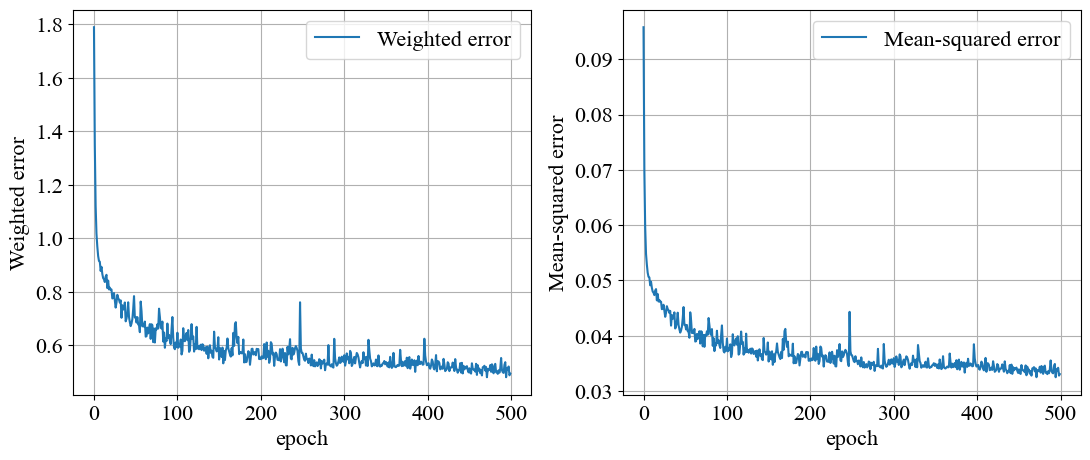

In [4]:
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman'], 'font.size': 16})      
# Define the loss and accuracy for the training and test data
loss_train = []
mean_error_train = []
mean_error_pred = np.zeros(50)
loss_train.extend(history.history['loss'])
mean_error_train.extend(history.history['mean_squared_error'])
if PLOT_TRAIN:
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.grid(True)
    plt.plot(np.array(loss_train).T)
    plt.ylabel('Weighted error')
    plt.xlabel('epoch')
    plt.legend(['Weighted error'])
    
    # plt.ylim([0, 0.7])
    plt.subplot(122)
    plt.grid(True)
    plt.plot((np.array(mean_error_train).T))
    plt.ylabel('Mean-squared error')
    plt.xlabel('epoch')
    plt.legend(['Mean-squared error'])
    #plt.ylim([0, 0.7])
    # plt.show()
    if WIRE_ANTENNA:
        plt.savefig('data/Wire_Results/Wire_train_loss_inverse2.pdf', bbox_inches='tight', format='pdf')
    # plt.savefig(f'data/DNN_results_reversal/train_loss/loss_{(j+1)*100}.png')
    else:
        plt.savefig('data/MIFA_Results/MIFA_train_loss_inverse2.pdf', bbox_inches='tight', format='pdf')
    
    plt.show()
    plt.close()



1688/1688 [==============================] - 2s 1ms/step
y_pred_norm shape: (54000, 4)


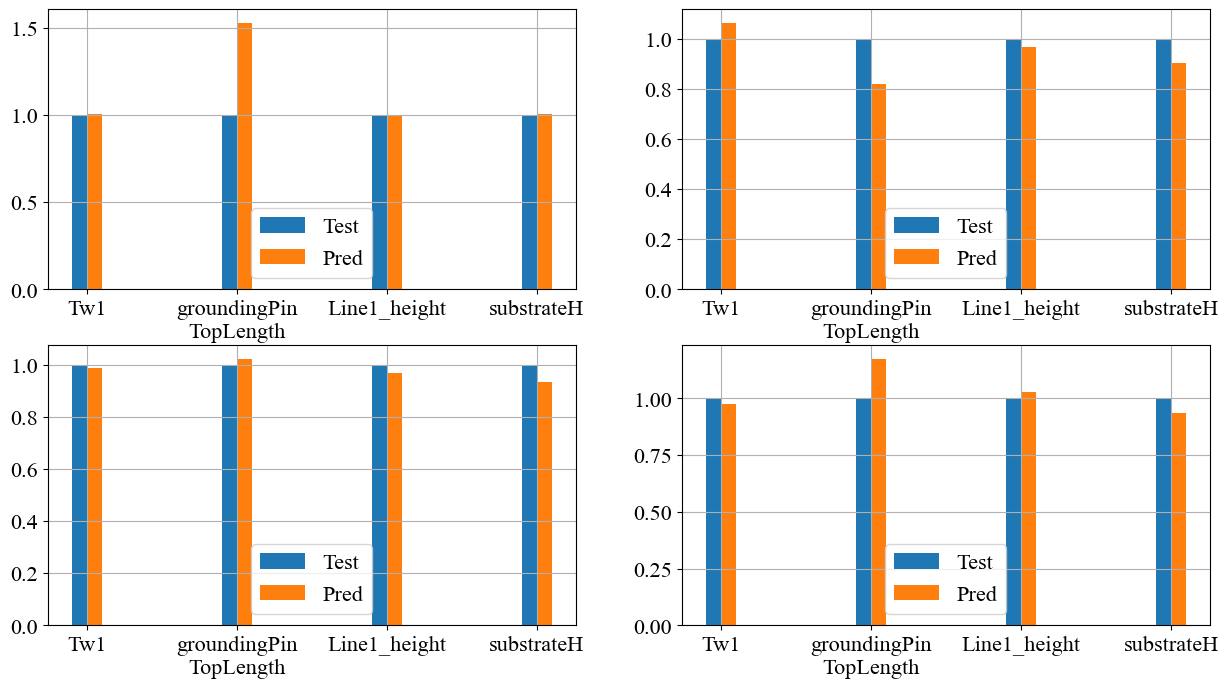

In [5]:
# Run the model on the test data and get the loss and mean-squared error
y_pred_norm = model.predict(x_test_norm)
# _ , mean_error_pred = model.evaluate(x_test_norm, y_test_norm)

#Reverse normalization
# Reverse the normalization of the data individually
print(f"y_pred_norm shape: {y_pred_norm.shape}")
y_pred = normalize_data(y_pred_norm, np.mean(y_train), np.std(y_train), True)


PLOT_TEST = True
# Plot the testing results
if PLOT_TEST:
    plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman'], 'font.size': 16})
    if WIRE_ANTENNA:
        # Make a grouped bar plot with the predicted parameters and the test parameters
        random_indices = random.sample(range(0, y_pred.shape[0]), 4)
        plt.figure(figsize=(15, 8))
        width = 0.1  # the width of the bars
        labels = ["Wire length", "Wire height", "Wire thickness"]
        for idx, i in enumerate(random_indices):
            plt.subplot(2, 2, idx+1)
            plt.grid(True)
            bars1 = plt.bar(np.arange(1,4) - width/2, y_test[i]/y_test[i], width)
            bars2 = plt.bar(np.arange(1,4) + width/2, y_pred[i]/y_test[i], width)
            plt.xticks(np.arange(1,4), labels)
            plt.legend([bars1, bars2], ['Test', 'Pred'],loc = 'lower center')
            plt.savefig('data/Wire_Results/Wire_bar_plot_inverse2.pdf', bbox_inches='tight', format='pdf')
            
    else:
        random_indices = random.sample(range(0, y_pred.shape[0]), 4)
        plt.figure(figsize=(15, 8))
        width = 0.1  # the width of the bars
        labels = ['Tw1','groundingPin\nTopLength','Line1_height','substrateH']
        for idx, i in enumerate(random_indices):
            plt.subplot(2, 2, idx+1)
            plt.grid(True)
            bars1 = plt.bar(np.arange(1,5) - width/2, y_test[i]/y_test[i], width)
            bars2 = plt.bar(np.arange(1,5) + width/2, y_pred[i]/y_test[i], width)
            plt.xticks(np.arange(1,5), labels)
            plt.legend([bars1, bars2], ['Test', 'Pred'],loc = 'lower center')
            plt.savefig('data/MIFA_Results/MIFA_bar_plot_inverse2.pdf', bbox_inches='tight', format='pdf')
    plt.show()


In [6]:
# Save model
if WIRE_ANTENNA:
    model.save('data/Wire_Results/Wire_Inverse_model_2.keras')
else:
    model.save('data/MIFA_results/MIFA_Inverse_model_2.keras')